In [143]:
import sys
import os
import argparse
import pickle
from typing import Optional, Union
from collections import defaultdict
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import sklearn

# PROJECT
ROOT_PATH = '/home/karina/ehr_ood_detection/'
sys.path.append(ROOT_PATH)

from src.utils.datahandler import DataHandler, load_data_from_origin
from src.models.novelty_estimator import NoveltyEstimator, SCORING_FUNCS
from src.utils.model_init import init_models

RESULT_DIR = os.path.join(ROOT_PATH, "data/results")
DATA_ORIGIN = "VUmc"

### Load features

In [100]:
# Define for compatibility with the IDE functions
Args = namedtuple("Args", 'data_origin, result_dir, models')
args = Args(DATA_ORIGIN, RESULT_DIR, {"NN"})

DENSITY_ESTIMATORS = {"AE", "VAE", "PPCA", "LOF", "DUE"}

In [10]:
# Load features
data_loader = load_data_from_origin(args.data_origin)
dh = DataHandler(**data_loader)
X_train, y_train, X_test, y_test, X_val, y_val = dh.get_processed_data(scale=True)
X_train.head()

,age,alat__first__overall,alat__is_measured__first_24h,alat__is_measured__last_24h,alat__is_measured__overall,alat__last__overall,alat__maximum__first_24h,alat__maximum__last_24h,alat__maximum__overall,alat__mean__first_24h,...,weight__mean__first_24h,weight__mean__last_24h,weight__mean__overall,weight__mean__overall__diff,weight__minimum__first_24h,weight__minimum__last_24h,weight__minimum__overall,weight__standard_deviation__first_24h,weight__standard_deviation__last_24h,weight__standard_deviation__overall
12776,0.208338,-2.571594e-17,-0.836748,-0.564198,-1.005234,1.341701e-17,-2.115117e-17,-1.396415e-17,1.900744e-17,-6.140661e-18,...,-0.592510,-6.437533e-17,-0.599947,-9.289658e-18,-0.571143,2.327858e-16,-0.566624,-0.124656,-8.046917e-18,-0.175002
8728,-1.841463,1.497769e-01,-0.836748,-0.564198,0.994794,1.903120e-01,-2.115117e-17,-1.396415e-17,-2.725539e-02,-6.140661e-18,...,0.632517,-6.437533e-17,0.619133,-9.289658e-18,0.664125,2.327858e-16,0.667501,-0.174363,-8.046917e-18,-0.219490
10988,1.234953,1.815384e-01,1.195102,-0.564198,0.994794,-1.107904e-01,5.204464e-02,-1.396415e-17,1.991159e-01,6.813280e-02,...,-0.594964,-6.437533e-17,-0.602390,-9.289658e-18,-0.571143,2.327858e-16,-0.566624,-0.174363,-8.046917e-18,-0.219490
6797,-0.061668,-2.571594e-17,-0.836748,-0.564198,-1.005234,1.341701e-17,-2.115117e-17,-1.396415e-17,1.900744e-17,-6.140661e-18,...,1.798624,1.786848e+00,1.779579,-2.300083e-03,1.837631,1.807144e+00,1.839919,-0.174363,-1.071439e-01,-0.219490
9590,-1.586001,-2.571594e-17,-0.836748,-0.564198,-1.005234,1.341701e-17,-2.115117e-17,-1.396415e-17,1.900744e-17,-6.140661e-18,...,-1.951331,-6.437533e-17,-1.950645,-9.289658e-18,-1.948468,2.327858e-16,-1.942673,-0.115783,-8.046917e-18,-0.171330


### Train novelty estimator

In [163]:
novelty_estimators = defaultdict(dict)

for model_info in init_models(input_dim=X_train.shape[1], 
                              selection=args.models, 
                              origin=args.data_origin):
    
    print("\n\n", model_info[2])
    ne, scoring_funcs, method_name = model_info
    
    ne.train(X_train.values, y_train.values, X_val.values, y_val.values)
    
    novelty_estimators[method_name] = {"model": ne, "scoring_funcs": scoring_funcs}



 NN
Early stopping after 8 epochs.


### SHAP

In [105]:
f = lambda X: ne.get_novelty_score(data=X, scoring_func='entropy').flatten()

explainer = shap.KernelExplainer(f, shap.utils.sample(X_train.values, nsamples=100, random_state=0))
feature_names = list(map(lambda x: x.replace('_', ' '), X_test.columns))

index=191
shap_values = explainer.shap_values(X_test.loc[[index]].values)
shap.force_plot(explainer.expected_value, 
                shap_values[0], 
                feature_names, 
                out_names = f'uncertainty score',
                show=False,
                matplotlib=True)

plt.title(f'NN (entropy)\n \nID={index}\n  ', fontsize=14, y=100)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

In [160]:
def run_shap(novelty_estimator,
             scoring_func: str,
             X_train: pd.DataFrame,
             X_test: pd.DataFrame,
             indices: Union[int,list],
            ):
    
    if type(indices) is int:
        indices = list(indices)
        
    f = lambda X: ne.get_novelty_score(data=X, scoring_func=scoring_func).flatten()
    X_train_sample = shap.utils.sample(X_train.values, nsamples=100, random_state=0)
    
    shap_values = explainer.shap_values(X_test.loc[indices].values)
    
    feature_names = list(map(lambda x: x.replace('_', ' '), X_test.columns))
        
    for i,index in enumerate(indices):
        print(f'ID={index}')

        shap.force_plot(explainer.expected_value, 
                        shap_values[i], 
                        feature_names, 
                        out_names = f'novelty score',
                        show=False,
                        matplotlib=True)

        plt.title(ne.__dict__['name']+' '+ scoring_func +'\n'+ f'ID={index}', fontsize=14)
        plt.show()
            

  0%|          | 0/1 [00:00<?, ?it/s]

ID=191


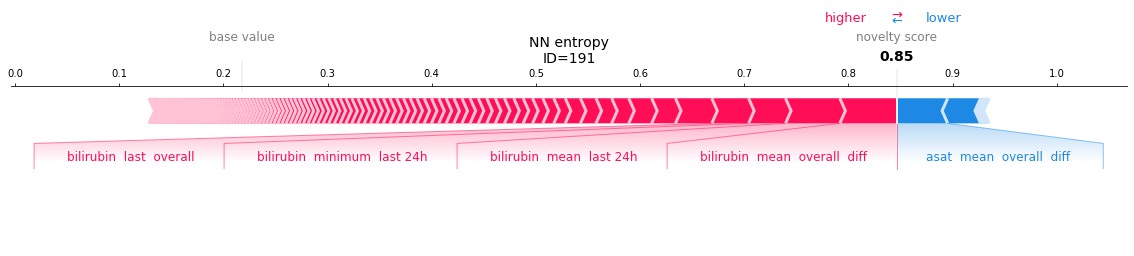

In [162]:
run_shap(ne, 'entropy', X_train, X_test, [191])